In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# Build a Transform function
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

# Load Dataset
train_data = datasets.CIFAR10('Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('Data', train=False, download=True, transform=transform)

trainloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers = 2)

In [4]:
class_name = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5) # 3 chanell input - 12 filter - kernel 5*5 (28, 28, 12)
        self.pool = nn.MaxPool2d(2, 2) # (14, 14, 12)
        self.conv2 = nn.Conv2d(12, 24, 5) # (10, 10, 24) -> (5, 5, 24) -flatten-> vector(5 * 5 * 24)
        self.fc1 = nn.Linear(5 * 5 * 24, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
net = Model()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [12]:
losses = []
net.train()

for epoch in range(30):
    print(f'Training epoch {epoch}...')

    running_loss = 0.0
    
    for _, data in enumerate(trainloader):
        images, labels = data
        optimizer.zero_grad()

        outputs = net(images)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss
        losses.append(loss.item())

    print(f'loss: {running_loss / len(trainloader):.4f}')

Training epoch 0...
loss: 1.6040
Training epoch 1...
loss: 1.2854
Training epoch 2...
loss: 1.1272
Training epoch 3...
loss: 1.0220
Training epoch 4...
loss: 0.9431
Training epoch 5...
loss: 0.8801
Training epoch 6...
loss: 0.8306
Training epoch 7...
loss: 0.7900
Training epoch 8...
loss: 0.7472
Training epoch 9...
loss: 0.7088
Training epoch 10...
loss: 0.6766
Training epoch 11...
loss: 0.6455
Training epoch 12...
loss: 0.6096
Training epoch 13...
loss: 0.5872
Training epoch 14...
loss: 0.5618
Training epoch 15...
loss: 0.5315
Training epoch 16...
loss: 0.5070
Training epoch 17...
loss: 0.4893
Training epoch 18...
loss: 0.4681
Training epoch 19...
loss: 0.4389
Training epoch 20...
loss: 0.4281
Training epoch 21...
loss: 0.4052
Training epoch 22...
loss: 0.3870
Training epoch 23...
loss: 0.3692
Training epoch 24...
loss: 0.3591
Training epoch 25...
loss: 0.3420
Training epoch 26...
loss: 0.3237
Training epoch 27...
loss: 0.3129
Training epoch 28...
loss: 0.2985
Training epoch 29...
los

In [10]:
torch.save(net.state_dict(), 'trained_net_pth')

In [6]:
net = Model()
net.load_state_dict(torch.load('trained_net_pth'))

<All keys matched successfully>

In [13]:
# Evaluation 
total = 0
correct = 0

net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}')

Accuracy: 65.33


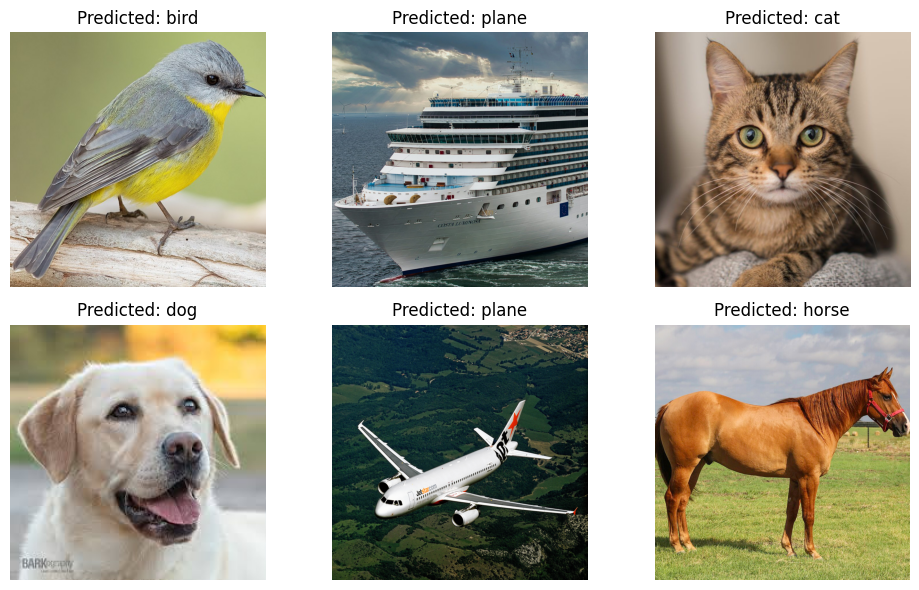

In [8]:
from torchvision.transforms import ToPILImage

new_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


def load_image(image_path):
    image = Image.open(f'test-images/{image_path}')
    image = new_transform(image)
    image = image.unsqueeze(0)
    return image



image_paths = ['bird.jpg', 'ship.jpg', 'cat.jpg', 'dog.jfif', 'airplane.jpg', 'horse.jpg']
images = [load_image(img) for img in image_paths]

fig, axs = plt.subplots(2, 3, figsize=(10, 6)) 
axs = axs.reshape(2, 3)  

predicteds = []
net.eval()
with torch.no_grad():
    for image in images:
        output = net(image)
        _, predicted = torch.max(output, 1)
        predicteds.append(predicted)


for i, image_path in enumerate(image_paths):
    image = Image.open(f'test-images/{image_path}')
    row, col = divmod(i, 3)  
    ax = axs[row, col]
    
    ax.imshow(image)
    ax.set_title(f'Predicted: {class_name[predicteds[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()